In [1]:
# pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

/var/folders/0w/fv69fs7s6959xkvtvbw8_7h80000gn/T/ipykernel_10918/151664118.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import Data

In [3]:
#Import Dataset
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_features_standardized.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())
# print(labeled_index)

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
# print(features_columns)

# Build the model

In [4]:
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    scale_pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)
    
    if not all(label == 0 for label in y_val):
        param_grid = {'max_depth':[4,6], 
            'n_estimators':[150,250], 
            'learning_rate':[0.15,0.1],
            'scale_pos_weight':[scale_pos_weight], 
            'subsample': [0.6],
            'gamma': [0.05,0.1],
            'colsample_bytree': [0.6],
            'min_child_weight': [1.5,2],
            # 'reg_alpha': [0.5],
            'reg_lambda': [1.0,1.5]}
        grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), param_grid, cv=tscv, scoring='f1', verbose=3)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print(f"Best Param: {best_params}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]

    # Train the model
    model = xgb.XGBClassifier(objective='binary:logistic',
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        scale_pos_weight=scale_pos_weight,
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        gamma=best_params['gamma'],
        min_child_weight=best_params['min_child_weight'],
        reg_lambda=best_params['reg_lambda']
        # scale_pos_weight=best_params['scale_pos_weight']
    )
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    # joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict decision values on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Calculate feature importance
    feature_names = list(X_train.columns)
    feature_importance = model.feature_importances_
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.625, subsample=0.6;, score=0.000 total time=   0.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.625, subsample=0.6;, score=0.000 total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.625, subsample=0.6;, score=0.000 total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.625, subsample=0.6;, score=0.000 total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.05, learning_rate=0.15, max_depth=4, min_child_weight=1.5, n_estima

In [5]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_XGBoost_features.csv", index=False)
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,10YGov_BondYield_importance,current_acct_importance,FX_Rate_importance,turnover_importance,Population_importance,npl_importance,Recession_Indicators_importance,inflation_importance,Unemployment_importance,GDP_importance
0,1998-03-31,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[64, 4], [2, 0]]",0.000000,0.000000,0.000000,...,0.076263,0.015619,0.018042,0.026310,0.029720,0.030054,0.024827,0.010335,0.021935,0.025874
1,1998-03-31,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[29, 13], [12, 16]]",0.551724,0.571429,0.561404,...,0.037360,0.025629,0.028012,0.041832,0.013448,0.028368,0.083049,0.012621,0.012268,0.027627
2,1998-03-31,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[59, 5], [0, 6]]",0.545455,1.000000,0.705882,...,0.046209,0.021511,0.030833,0.022752,0.027796,0.041345,0.148959,0.022209,0.021545,0.023864
3,1998-03-31,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[57, 2], [7, 4]]",0.666667,0.363636,0.470588,...,0.051369,0.017802,0.025412,0.040954,0.023714,0.040789,0.112626,0.016953,0.016993,0.020577
4,1998-03-31,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[59, 10], [0, 1]]",0.090909,1.000000,0.166667,...,0.053100,0.030898,0.025657,0.037508,0.021785,0.039502,0.136322,0.016795,0.016950,0.017829


## Shap Values

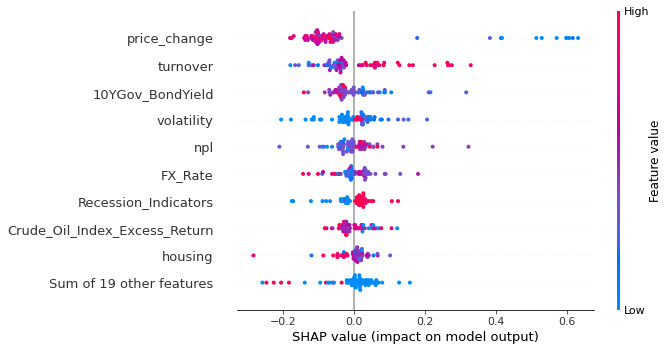

In [6]:
shap.plots.beeswarm(shap_values_list[4])

# Feature Importance

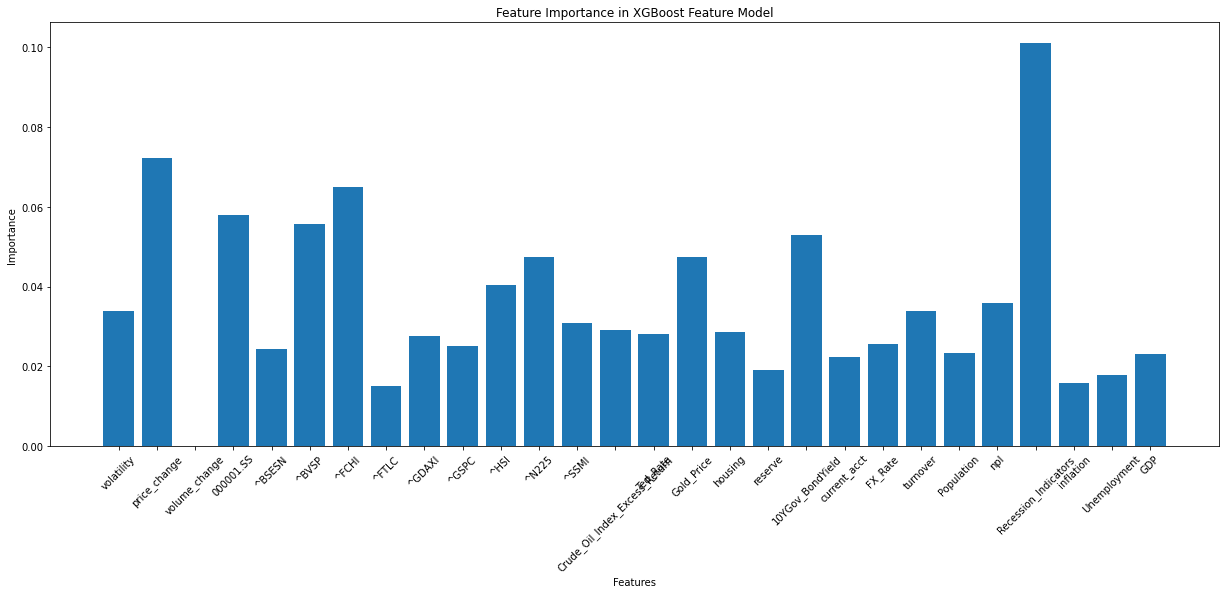

In [7]:
model_name = "XGBoost Feature"
plot_feature_importances(evaluation_df, model_name)

# AUC-ROC

In [8]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.8160788425623482


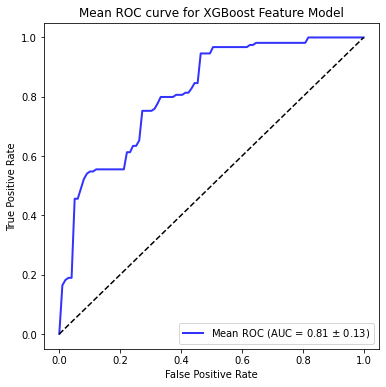

In [9]:
plot_roc_curve(evaluation_df, model_name)

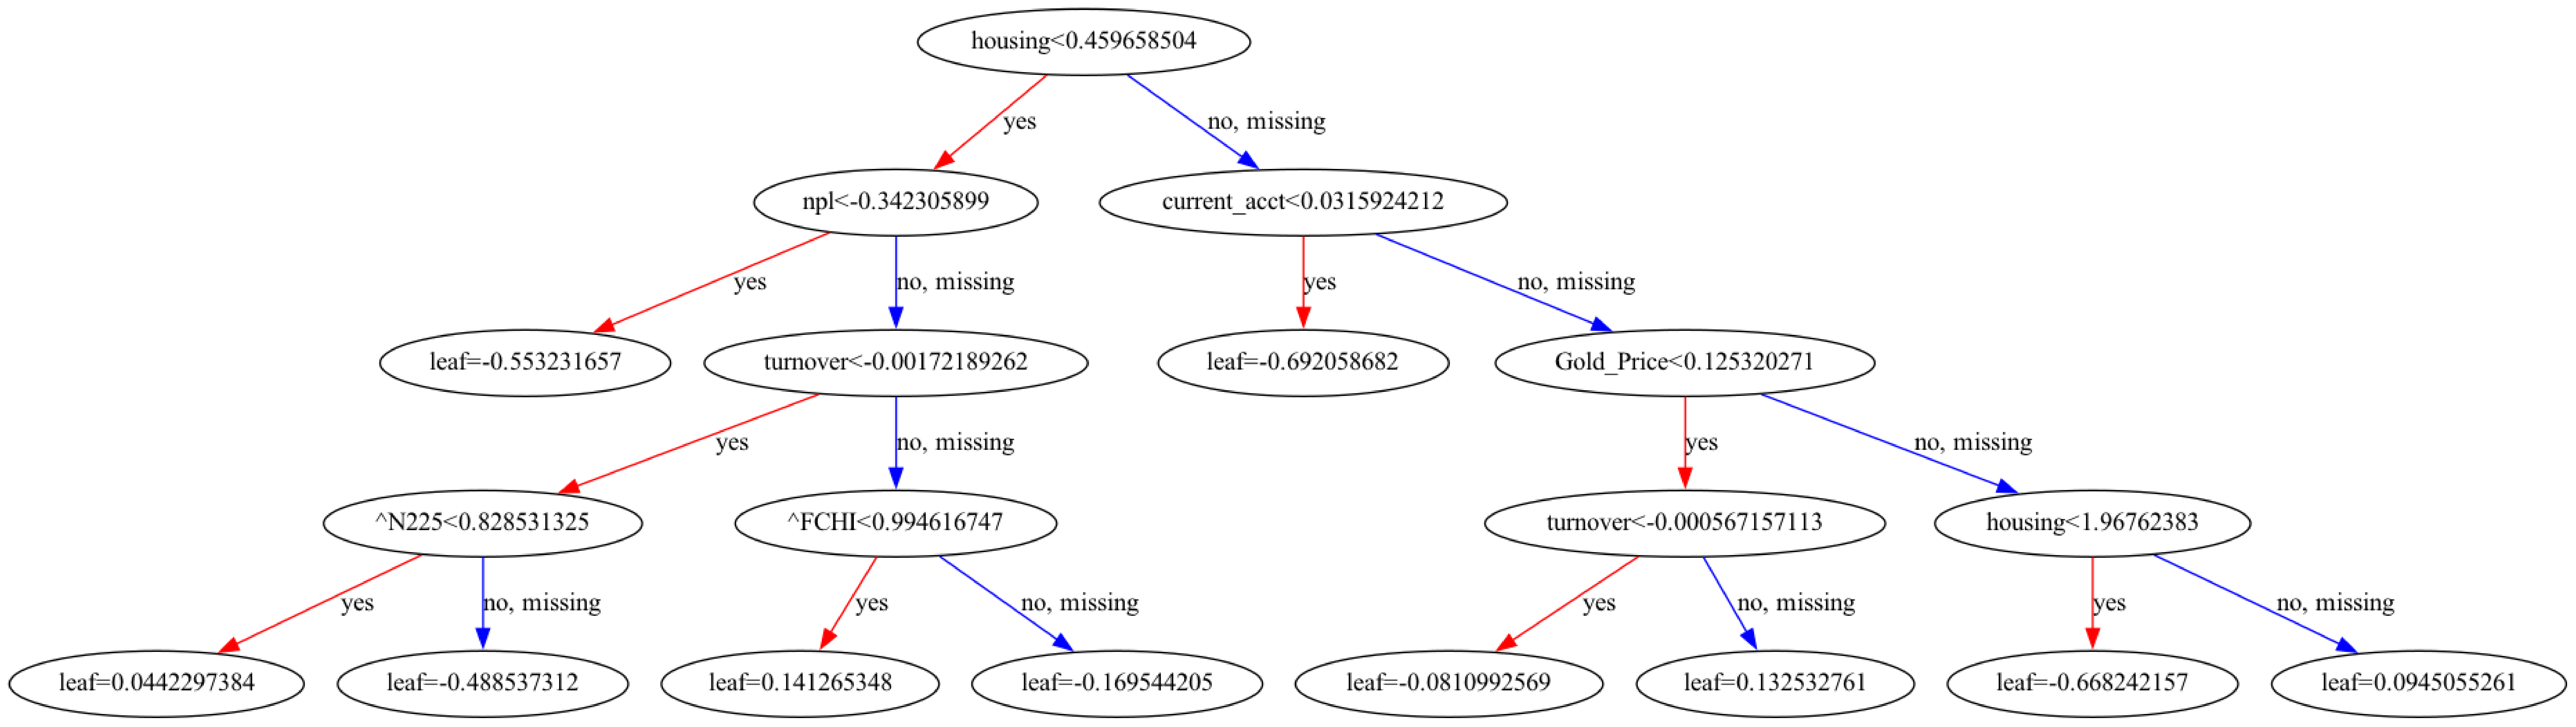

In [10]:
# pip install graphviz
fig, ax = plt.subplots(figsize=(170, 170))
xgb.plot_tree(model, ax=ax)
plt.show()